### 1. Read in the enriched PartB data for year 2013 & 2014

In [2]:
import pandas as pd
import numpy as np
import sklearn
import random
import cloudpickle
import os 
import warnings
warnings.filterwarnings('ignore')

parent = os.path.dirname(os.getcwd())
df = pd.read_csv(parent + '/Capstone_project/data/year2013_2014_combined_with_labels.csv')

df.fillna(0, inplace=True)

print(sum(df.Fraud_Indicator ==1))

df['Rndrng_Prvdr_Type'] = df['Rndrng_Prvdr_Type'].astype('category').cat.codes
df['Rndrng_Prvdr_Gndr'] = df['Rndrng_Prvdr_Gndr'].astype('category').cat.codes
df['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'] = df['Rndrng_Prvdr_Mdcr_Prtcptg_Ind'].astype('category').cat.codes

print(df.shape)

2550
(1847558, 89)


### 2. Split the data to a train set (used for cross validation) and a test set (holdout)

In [3]:
# split out the holdout data by Rndrng_NPI to avoid data leakage
random.seed(42)
holdout_rate = 0.1

uniq_id = df.Rndrng_NPI.unique()
holdout_set = random.sample(list(uniq_id), int(len(uniq_id)*holdout_rate))
train_set = list(set(uniq_id) - set(holdout_set))

train=df.query("`Rndrng_NPI` in @train_set")
holdout=df.query("`Rndrng_NPI` in @holdout_set")

train_X = train.drop(columns=['Rndrng_NPI', 'Fraud_Indicator','YEAR'])
train_y = train.Fraud_Indicator

test_X = holdout.drop(columns=['Rndrng_NPI', 'Fraud_Indicator','YEAR'])
test_y = holdout.Fraud_Indicator

print(train_X.shape, test_X.shape)

(1662708, 86) (184850, 86)


### 3. Build up a pipeline including evaluation

In [4]:
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# define pipeline
def lgbm_roc_auc_eval(undersample_rate= None, n_iter = 100):

    lgbm = LGBMClassifier(objective='binary', class_weight='balanced', random_state=42, n_jobs=-1, verbose=-1)
    
    if undersample_rate == None:
        steps = [
#             ('scaler', StandardScaler()),
                 ('clf', lgbm)]
        
    elif undersample_rate != None:
        under = RandomUnderSampler(sampling_strategy=undersample_rate, random_state =42)
        steps = [('under', under), 
#                  ('scaler', StandardScaler()),
                 ('clf', lgbm)]

    pipeline = Pipeline(steps=steps)

    skf = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

    param_grid  = {
                'clf__max_bin': [20, 30, 50, 70, 100, 150, 200, 250, 300],
                'clf__objective' : ['binary'],
                'clf__metric':['auc'],
                'clf__num_leaves': [16, 35, 65, 128, 256],
                'clf__max_depth' : [4, 5, 6, 7, 8],
                'clf__learning_rate': [0.05, 0.01, 0.1, 0.03, 0.001, 0.005],
                'clf__min_data_in_leaf': [100, 200, 300, 500, 700, 800, 1000, 1500],
                'clf__min_sum_hessian_in_leaf': [0.000001, 0.00001, 0.0001, 0.001, 0.01],
                'clf__bagging_fraction': [0.1, 0.3, 0.5, 0.7, 0.9], 
                'clf__bagging_freq': [2, 4, 5, 6, 8, 10],
                'clf__feature_fraction': [0.1,0.3,0.5,0.7,0.9],
                'clf__lambda_l1': [0, 0.1, 0.5, 0.6, 1., 2., 5., 6., 7., 8., 9.],
                'clf__lambda_l2': [0, 0.1, 0.5, 0.6, 1., 2., 5., 6., 7., 8., 9.],   
                'clf__num_iterations': [100, 200, 500, 700, 1000, 1500, 2000, 3000, 3500, 5000],
                'clf__random_state' : [42],
                'clf__boosting_type' : ['gbdt', 'dart', 'random_forest'],
                'clf__is_unbalance': [True]
                 }
  
    grid_pipe = RandomizedSearchCV(estimator = pipeline, 
                                   param_distributions= param_grid,
                                   n_iter = n_iter,
                                   scoring= 'roc_auc', 
                                   refit=True,
                                   n_jobs =-1,
                                   cv = skf,
                                   random_state=42,
                                   verbose = True)
    
    grid_result = grid_pipe.fit(train_X, train_y, 
                                clf__categorical_feature=['Rndrng_Prvdr_Type',
                                                          'Rndrng_Prvdr_Gndr',
                                                          'Rndrng_Prvdr_Mdcr_Prtcptg_Ind'])
    
    print('Best Score: ', grid_result.best_score_)
    print('Best Params: ', grid_result.best_params_)
    

    scores = cross_val_score(grid_result.best_estimator_, train_X, train_y, scoring = 'roc_auc', cv=skf, n_jobs=-1)
    print('Mean ROC AUC: %.3f' % np.mean(scores), 
          'SD ROC AUC: %.4f' % np.std(scores))
    
    val_auc = roc_auc_score(test_y, grid_result.best_estimator_.predict_proba(test_X)[:, 1])
    print('Test set ROC AUC  %.3f' % val_auc)
    return round(np.mean(scores), 4), round(np.std(scores), 5), round(val_auc, 4), grid_result.best_estimator_

def plot_confusion_matrix(estimator, test_X, test_y):
    # Create the NumPy array for actual and predicted labels.
    actual    = test_y
    predicted = estimator.predict(test_X)

    # compute the confusion matrix.
    cm = confusion_matrix(actual, predicted)

    # Plot the confusion matrix.
    sns.heatmap(cm,
                annot=True,
                fmt='g',
                xticklabels=['Non-Fraud','Fraud'],
                yticklabels=['Non-Fraud','Fraud'])
    plt.ylabel('Actual',fontsize=15)
    plt.xlabel('Prediction',fontsize=15)
    plt.title('Confusion Matrix', fontsize=17)
    return plt.show()

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Score:  0.8766518449425537
Best Params:  {'clf__random_state': 422, 'clf__objective': 'binary', 'clf__num_leaves': 65, 'clf__num_iterations': 3000, 'clf__min_sum_hessian_in_leaf': 1e-05, 'clf__min_data_in_leaf': 100, 'clf__metric': 'auc', 'clf__max_depth': 6, 'clf__max_bin': 20, 'clf__learning_rate': 0.03, 'clf__lambda_l2': 6.0, 'clf__lambda_l1': 6.0, 'clf__is_unbalance': True, 'clf__feature_fraction': 0.5, 'clf__boosting_type': 'gbdt', 'clf__bagging_freq': 6, 'clf__bagging_fraction': 0.7}
Mean ROC AUC: 0.869 SD ROC AUC: 0.0049
Test set ROC AUC  0.826
(0.8692, 0.00489, 0.8264)


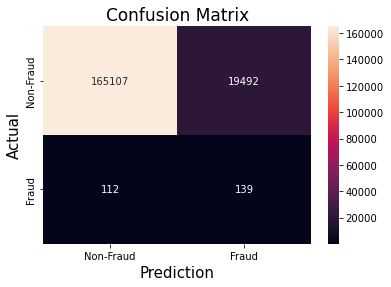

In [3]:
# undersample the majority/minority labels to ratio 10:1
lgbm_1 = lgbm_roc_auc_eval(0.1, 100)
print(lgbm_1[:3])
lgbm_pipe1 = lgbm_1[3]
plot_confusion_matrix(lgbm_pipe1, test_X, test_y)

cloudpickle.dump(lgbm_pipe1, open('lgbm_pipe1.cloudpickle','wb'))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Score:  0.8683781437177376
Best Params:  {'clf__random_state': 42, 'clf__objective': 'binary', 'clf__num_leaves': 65, 'clf__num_iterations': 3000, 'clf__min_sum_hessian_in_leaf': 1e-05, 'clf__min_data_in_leaf': 100, 'clf__metric': 'auc', 'clf__max_depth': 6, 'clf__max_bin': 20, 'clf__learning_rate': 0.03, 'clf__lambda_l2': 6.0, 'clf__lambda_l1': 6.0, 'clf__is_unbalance': True, 'clf__feature_fraction': 0.5, 'clf__boosting_type': 'gbdt', 'clf__bagging_freq': 6, 'clf__bagging_fraction': 0.7}
Mean ROC AUC: 0.861 SD ROC AUC: 0.0035
Test set ROC AUC  0.823
(0.8612, 0.00346, 0.8229)


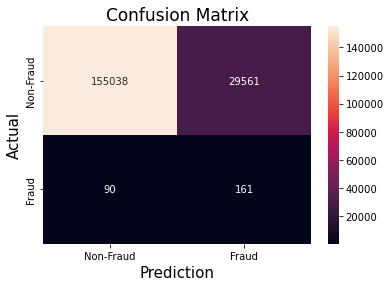

In [5]:
# undersample the majority/minority labels to ratio 4:1 (80:20)
lgbm_2 = lgbm_roc_auc_eval(0.25, 100)
print(lgbm_2[:3])
lgbm_pipe2 = lgbm_2[3]
plot_confusion_matrix(lgbm_pipe2, test_X, test_y)

cloudpickle.dump(lgbm_pipe2, open('lgbm_pipe2.cloudpickle','wb'))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Score:  0.8596220563852423
Best Params:  {'clf__random_state': 42, 'clf__objective': 'binary', 'clf__num_leaves': 65, 'clf__num_iterations': 3000, 'clf__min_sum_hessian_in_leaf': 1e-05, 'clf__min_data_in_leaf': 100, 'clf__metric': 'auc', 'clf__max_depth': 6, 'clf__max_bin': 20, 'clf__learning_rate': 0.03, 'clf__lambda_l2': 6.0, 'clf__lambda_l1': 6.0, 'clf__is_unbalance': True, 'clf__feature_fraction': 0.5, 'clf__boosting_type': 'gbdt', 'clf__bagging_freq': 6, 'clf__bagging_fraction': 0.7}
Mean ROC AUC: 0.850 SD ROC AUC: 0.0058
Test set ROC AUC  0.826
(0.8504, 0.00582, 0.8255)


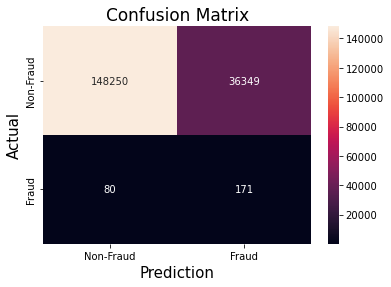

In [6]:
# undersample the majority/minority labels to ratio 2:1
lgbm_3 = lgbm_roc_auc_eval(0.5, 100)
print(lgbm_3[:3])
lgbm_pipe3 = lgbm_3[3]
plot_confusion_matrix(lgbm_pipe3, test_X, test_y)

cloudpickle.dump(lgbm_pipe3, open('lgbm_pipe3.cloudpickle','wb'))

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best Score:  0.8472077075727696
Best Params:  {'clf__random_state': 42, 'clf__objective': 'binary', 'clf__num_leaves': 256, 'clf__num_iterations': 1500, 'clf__min_sum_hessian_in_leaf': 1e-05, 'clf__min_data_in_leaf': 200, 'clf__metric': 'auc', 'clf__max_depth': 8, 'clf__max_bin': 200, 'clf__learning_rate': 0.01, 'clf__lambda_l2': 0.1, 'clf__lambda_l1': 0.5, 'clf__is_unbalance': True, 'clf__feature_fraction': 0.5, 'clf__boosting_type': 'gbdt', 'clf__bagging_freq': 10, 'clf__bagging_fraction': 0.9}
Mean ROC AUC: 0.838 SD ROC AUC: 0.0068
Test set ROC AUC  0.824
(0.8376, 0.00678, 0.8242)


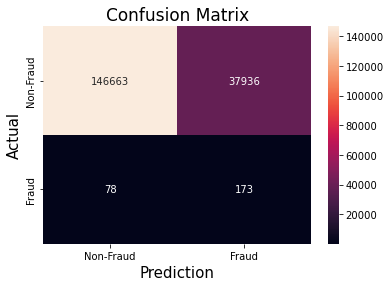

In [7]:
# undersample the majority/minority labels to ratio 1:1
lgbm_4 = lgbm_roc_auc_eval(1, 100)
print(lgbm_4[:3])
lgbm_pipe4 = lgbm_4[3]
plot_confusion_matrix(lgbm_pipe4, test_X, test_y)

cloudpickle.dump(lgbm_pipe4, open('lgbm_pipe4.cloudpickle','wb'))